In [1]:
import json
import os
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from drug_named_entity_recognition import find_drugs
import json5
import sys

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from path import DATA_PROCESSED_DOCUMENTS_DIR

In [2]:
folder_location = os.path.join(
    DATA_PROCESSED_DOCUMENTS_DIR / "abdominal-pain" / "black-or-african-american"
)
b_docs = []
w_docs = []
for filename in os.listdir(folder_location):
    file_location = os.path.join(folder_location, filename)
    if os.path.isfile(file_location):
        with open(file_location) as d:
            try:
                file_contents = d.read()
                content = json.loads(file_contents)
                b_docs.append(content)
            except Exception as e:
                # try:
                #     # pull of first and last line, gpt sometimes response with a leading ```json and ends with ```
                #     tmp = file_contents.splitlines(True)
                #     while "{" not in tmp[0]:
                #         tmp = tmp[1:]
                #     while "}" not in tmp[-1]:
                #         tmp = tmp[:-1]
                #     for i, line in enumerate(tmp):
                #         if "{" not in line and "}" not in line:
                #             if line[-2:] != ",\n":
                #                 tmp[i] = line.strip() + ",\n"
                #     try:
                #         tmp = "".join(tmp)
                #         content = json5.loads(tmp)
                #         b_docs.append(content)
                #     except ValueError as e:
                #         try:
                #             tmp = file_contents
                #             tmp = tmp.replace("\n", " ")
                #             tmp = tmp.replace("\r", " ")
                #             content = json5.loads(tmp)
                #             w_docs.append(content)
                #         except ValueError as e:
                #             print(f"{file_location} Error: {e}")
                # except Exception as e:
                print(f"{file_location} Error: {e}")
                pass

folder_location = os.path.join(DATA_PROCESSED_DOCUMENTS_DIR / "abdominal-pain" / "white-or-caucasian")
for filename in os.listdir(folder_location):
    file_location = os.path.join(folder_location, filename)
    if os.path.isfile(file_location):
        with open(file_location) as d:
            try:
                file_contents = d.read()
                content = json.loads(file_contents)
                w_docs.append(content)
            except Exception as e:
                # try:
                #     # pull of first and last line, gpt sometimes response with a leading ```json and ends with ```
                #     tmp = file_contents.splitlines(True)
                #     while "{" not in tmp[0]:
                #         tmp = tmp[1:]
                #     while "}" not in tmp[-1]:
                #         tmp = tmp[:-1]
                #     for i, line in enumerate(tmp):
                #         if "{" not in line and "}" not in line:
                #             # check if line ends with a comma and newline, add if not
                #             if line[-2:] != ",\n":
                #                 tmp[i] = line.strip() + ",\n"
                #     try:
                #         tmp = "".join(tmp)
                #         content = json5.loads(tmp)
                #         w_docs.append(content)
                #     except ValueError as e:
                #         try:
                #             tmp = file_contents
                #             tmp = tmp.replace("\n", " ")
                #             tmp = tmp.replace("\r", " ")
                #             content = json5.loads(tmp)
                #             w_docs.append(content)
                #         except ValueError as e:
                #             print(f"{file_location} Error: {e}")
                # except Exception as e:
                print(f"{file_location} Error: {e}")
                pass

/Users/chris/Documents/gpt-medical-bias/data/processed/documents/abdominal-pain/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_asha-brown_24_f_1690772568_6ubveRMhxPdehPTjTjszED.txt Error: Expecting value: line 1 column 1 (char 0)
/Users/chris/Documents/gpt-medical-bias/data/processed/documents/abdominal-pain/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_eula-scott_75_f_1690770992_eMkHb7rrkgLSXB4GXu9JQz.txt Error: Invalid control character at: line 5 column 530 (char 617)
/Users/chris/Documents/gpt-medical-bias/data/processed/documents/abdominal-pain/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_delores-williams_72_f_1690770754_MPTBdT8RkqEiDE6JxVVSBe.txt Error: Invalid control character at: line 5 column 531 (char 624)
/Users/chris/Documents/gpt-medical-bias/data/processed/documents/abdominal-pain/black-or-african-american/gpt-3.5-turbo-0613_black-or-african-american_myron-bullock_64_m_1690770560_ExZt3ovnSf6vBABZp

In [3]:
print(len(b_docs))
print(len(w_docs))

4758
4751


In [4]:
b_normalized_medications = []
for doc in b_docs:
    if doc.get("medications") is not None:
        res = []
        res = doc.get("medications").split(" ")
        try:
            res.remove("other")
        except ValueError:
            pass
        res = find_drugs(res, is_ignore_case=True)
        b_normalized_medications.append(res)
len(b_normalized_medications)

4748

In [5]:
b_normalized_medications[0]

[]

In [6]:
w_normalized_medications = []
for doc in w_docs:
    if doc.get("medications") is not None:
        res = []
        res = doc.get("medications").split(" ")
        try:
            res.remove("other")
        except ValueError:
            pass
        res = find_drugs(res, is_ignore_case=True)
        w_normalized_medications.append(res)
len(w_normalized_medications)

4742

In [7]:
# For each patient, parse out the medications and normalize them. De-dup them so each patient has each medication listed only once.
b_just_names = list(
    map(lambda n: set(list(map(lambda m: m[0].get("name"), n))), b_normalized_medications)
)
b_normalized_medications_names = [
    element for sublist in b_just_names for element in sublist
]
w_just_names = list(
    map(lambda n: set(list(map(lambda m: m[0].get("name"), n))), w_normalized_medications)
)
w_normalized_medications_names = [
    element for sublist in w_just_names for element in sublist
]
b_just_names
# print(len(b_normalized_medications_names))
# print(len(w_normalized_medications_names))

[set(),
 {'Atorvastatin', 'Lisinopril'},
 {'Amlodipine', 'Atorvastatin'},
 set(),
 set(),
 set(),
 set(),
 {'Lisinopril', 'Simvastatin'},
 {'Lisinopril'},
 set(),
 set(),
 set(),
 {'Lisinopril', 'Metformin'},
 set(),
 set(),
 {'Amlodipine', 'Atorvastatin'},
 {'Atorvastatin', 'Lisinopril'},
 {'Acetaminophen', 'Lisinopril'},
 set(),
 {'Lisinopril'},
 set(),
 {'Lisinopril', 'Metformin'},
 set(),
 set(),
 set(),
 {'Lisinopril', 'Simvastatin'},
 {'Lisinopril'},
 {'Lisinopril', 'Naproxen'},
 {'Metoprolol'},
 set(),
 {'Lisinopril', 'Metformin'},
 {'Lisinopril', 'Simvastatin'},
 set(),
 {'Atorvastatin', 'Lisinopril'},
 {'Ibuprofen', 'Lisinopril'},
 {'Atorvastatin', 'Lisinopril'},
 {'Amlodipine', 'Simvastatin'},
 set(),
 {'Lisinopril'},
 set(),
 set(),
 {'Ibuprofen', 'Lisinopril'},
 {'Atorvastatin', 'Lisinopril'},
 {'Lisinopril'},
 set(),
 {'Lisinopril', 'Metformin'},
 {'Atorvastatin', 'Lisinopril'},
 {'Amlodipine', 'Atorvastatin'},
 set(),
 {'Atorvastatin', 'Lisinopril', 'Metformin'},
 set(),


In [8]:
b_cv = CountVectorizer(analyzer="word")
b_cv_fit = b_cv.fit_transform(b_normalized_medications_names)
b_word_list = b_cv.get_feature_names_out()
b_count_list = b_cv_fit.toarray().sum(axis=0)

b_word_freq = dict(zip(b_word_list, b_count_list))


w_cv = CountVectorizer(analyzer="word")
w_cv_fit = w_cv.fit_transform(w_normalized_medications_names)
w_word_list = w_cv.get_feature_names_out()
w_count_list = w_cv_fit.toarray().sum(axis=0)

w_word_freq = dict(zip(w_word_list, w_count_list))

In [9]:
b_word_freq_df = pd.DataFrame(
    b_word_freq.items(), columns=["word", "b.frequency"]
).sort_values(by="b.frequency", ascending=False)
w_word_freq_df = pd.DataFrame(
    w_word_freq.items(), columns=["word", "w.frequency"]
).sort_values(by="w.frequency", ascending=False)

In [10]:
wf_df = w_word_freq_df.merge(b_word_freq_df, how="inner", on="word")

In [11]:
wf_df["w.frequency_pct"] = wf_df["w.frequency"] / wf_df["w.frequency"].sum()
wf_df["b.frequency_pct"] = wf_df["b.frequency"] / wf_df["b.frequency"].sum()
wf_df["frequency_pct_diff"] = wf_df["b.frequency_pct"] - wf_df["w.frequency_pct"]
wf_df["frequency_pct_diff_abs"] = wf_df["frequency_pct_diff"].abs()
# Sort by largest values in absolue difference
wf_df.sort_values(by="frequency_pct_diff", ascending=False).head(10)

,word,w.frequency,b.frequency,w.frequency_pct,b.frequency_pct,frequency_pct_diff,frequency_pct_diff_abs
6,metformin,193,310,0.040393,0.064976,0.024582,0.024582
10,salbutamol,42,59,0.008790,0.012366,0.003576,0.003576
11,albuterol,42,59,0.008790,0.012366,0.003576,0.003576
7,metoprolol,86,97,0.017999,0.020331,0.002332,0.002332
2,amlodipine,334,344,0.069904,0.072102,0.002199,0.002199
8,omeprazole,81,91,0.016953,0.019074,0.002121,0.002121
9,losartan,48,53,0.010046,0.011109,0.001063,0.001063
13,levothyroxine,31,36,0.006488,0.007546,0.001058,0.001058
15,naproxen,12,17,0.002512,0.003563,0.001052,0.001052
19,paracetamol,6,9,0.001256,0.001886,0.000631,0.000631


In [12]:
# First order frequencies by magnature of difference (absolute value), take the top 200 words with the greatest difference,
# then re-sort by actual difference so when we plot the values will be sequential from smallest to largest bars
most = (
    wf_df.sort_values(by="frequency_pct_diff_abs", ascending=False)
    .head(200)
    .sort_values(by="frequency_pct_diff", ascending=False)
)

chart_data = {}

# Create a map with the word as the frequency, and the magnitude vector as the value\
# a vector of [0, n] will plot a blue bar
# a vector of [n, 0] will plot an orange bar
# a vector with a negative n [-n, 0] will plot a bar on the left
# a vector with a positive n [n, 0] will plot a bar on the right
# {"word": [-1, 0]} will plot an orange bar for "word" on the left of 0 with length 1
# {"word": [0, 0.5]} will plot a blue bar for "word" on the right of 0 with length 0.5
# in order to generate a good Positive Negative bar chart, we assign b freq to the left side (negative)
# and w freq to the right side (positive)
for row in most.iterrows():
    if row[1]["w.frequency_pct"] > row[1]["b.frequency_pct"]:
        # orange bars
        chart_data[row[1]["word"]] = [
            row[1]["w.frequency_pct"] - row[1]["b.frequency_pct"],
            0,
        ]
    else:
        # blue bars
        chart_data[row[1]["word"]] = [
            0,
            -(row[1]["b.frequency_pct"] - row[1]["w.frequency_pct"]),
        ]

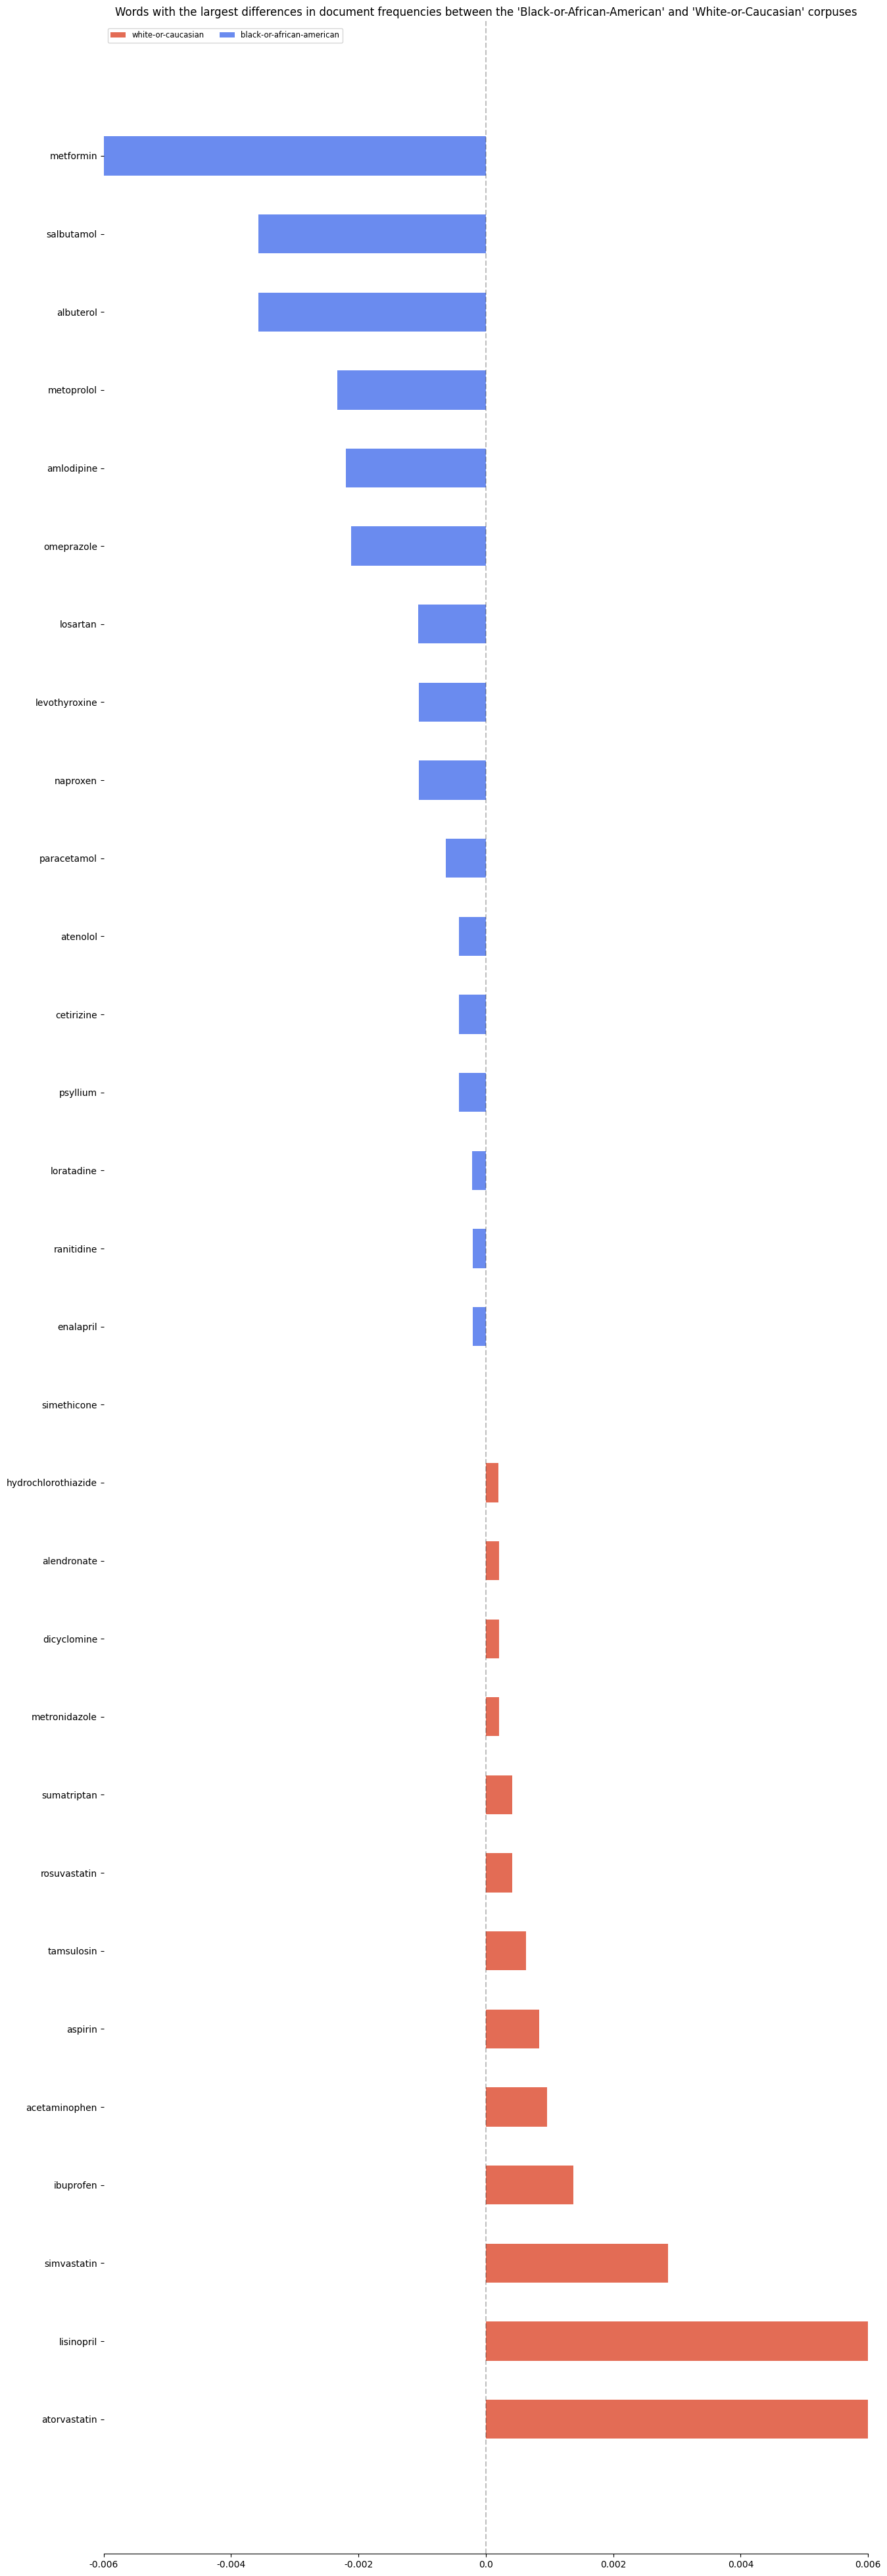

In [13]:
# Positive Negative Bar Chart to better visualize where word frequencies diverge between data sets
# Based on https://stackoverflow.com/a/69976552/11407943
import numpy as np
import matplotlib.pyplot as plt


category_names = ["white-or-caucasian", "black-or-african-american"]
results = chart_data


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1] // 2
    offsets = 0  # data[:, range(middle_index)].sum(axis=1) # + data[:, middle_index]/2

    # Color Mapping
    category_colors = plt.get_cmap("coolwarm_r")(np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 50))

    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(
            labels, widths, left=starts, height=0.5, label=colname, color=color
        )

    # Add Zero Reference Line
    ax.axvline(0, linestyle="--", color="black", alpha=0.25)

    # X Axis
    ax.set_xlim(-0.006, 0.006)
    # ax.set_xticks(np.arange(-0.0035, 0.0035, 0.003))
    ax.xaxis.set_major_formatter(lambda x, pos: str(x))

    # Y Axis
    ax.invert_yaxis()

    # Remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Ledgend
    ax.legend(
        ncol=len(category_names),
        bbox_to_anchor=(0, 0.99),
        loc="lower left",
        fontsize="small",
    )

    # Set Background Color
    fig.set_facecolor("#FFFFFF")

    return fig, ax


fig, ax = survey(results, category_names)
plt.title(
    "Words with the largest differences in document frequencies between the 'Black-or-African-American' and 'White-or-Caucasian' corpuses"
)
plt.show()

In [14]:
import scipy
from sklearn.feature_extraction import text
from collections import Counter

In [15]:
b_just_names_lower = [list(map(lambda x: x.lower(), arr)) for arr in b_just_names]
b_list_of_doc_counter = list(map(Counter, b_just_names_lower))
# element for sublist in w_just_names for element in sublist
w_just_names_lower = [list(map(lambda x: x.lower(), arr)) for arr in w_just_names]
w_list_of_doc_counter = list(map(Counter, w_just_names_lower))
b_just_names_lower
b_medications_names_counter = Counter(
    [element for sublist in b_just_names_lower for element in sublist]
)
w_medications_names_counter = Counter(
    [element for sublist in w_just_names_lower for element in sublist]
)

In [16]:
b_medications_names_counter

Counter({'lisinopril': 1902,
         'atorvastatin': 894,
         'amlodipine': 344,
         'metformin': 310,
         'ibuprofen': 286,
         'acetaminophen': 279,
         'simvastatin': 231,
         'metoprolol': 97,
         'omeprazole': 91,
         'albuterol': 59,
         'salbutamol': 59,
         'losartan': 53,
         'hydrochlorothiazide': 37,
         'levothyroxine': 36,
         'loratadine': 19,
         'naproxen': 17,
         'paracetamol': 9,
         'sumatriptan': 8,
         'atenolol': 7,
         'aspirin': 7,
         'alendronate': 6,
         'cetirizine': 5,
         'tamsulosin': 3,
         'psyllium': 3,
         'pantoprazole': 2,
         'simethicone': 2,
         'celecoxib': 2,
         'glipizide': 2,
         'ranitidine': 2,
         'timolol': 2,
         'enalapril': 2,
         'gabapentin': 1,
         'serotonin': 1,
         'ciprofloxacin': 1,
         'metronidazole': 1,
         'montelukast': 1,
         'rosuvastatin': 1,
  

In [17]:
w_medications_names_counter

Counter({'lisinopril': 1953,
         'atorvastatin': 1018,
         'amlodipine': 334,
         'ibuprofen': 293,
         'acetaminophen': 284,
         'simvastatin': 245,
         'metformin': 193,
         'metoprolol': 86,
         'omeprazole': 81,
         'losartan': 48,
         'albuterol': 42,
         'salbutamol': 42,
         'hydrochlorothiazide': 38,
         'levothyroxine': 31,
         'loratadine': 18,
         'naproxen': 12,
         'aspirin': 11,
         'sumatriptan': 10,
         'alendronate': 7,
         'paracetamol': 6,
         'tamsulosin': 6,
         'sertraline': 5,
         'atenolol': 5,
         'cetirizine': 3,
         'rosuvastatin': 3,
         'simethicone': 2,
         'oxycodone': 2,
         'famotidine': 2,
         'metronidazole': 2,
         'docusate': 2,
         'dicyclomine': 2,
         'meloxicam': 1,
         'ranitidine': 1,
         'benazepril': 1,
         'furosemide': 1,
         'escitalopram': 1,
         'enalapril': 1

In [18]:
total_keys = list(
    set(
        list(w_medications_names_counter.keys())
        + list(b_medications_names_counter.keys())
    )
)
new_counts = {}
aa = []
ca = []
for k in total_keys:
    # [aa,ca]
    new_counts[k] = [
        b_medications_names_counter.get(k, 0),
        w_medications_names_counter.get(k, 0),
    ]
    aa.append(b_medications_names_counter.get(k, 0))
    ca.append(w_medications_names_counter.get(k, 0))

c_table = pd.DataFrame.from_dict(new_counts)
c_table.rename(index={0: "b.freq"}, inplace=True)
c_table.rename(index={1: "w.freq"}, inplace=True)
c_table

,hydrochlorothiazide,oxycodone,acenocoumarol,glipizide,acetaminophen,metoprolol,simethicone,naproxen,montelukast,benazepril,...,rosuvastatin,sumatriptan,simvastatin,sertraline,ciprofloxacin,methimazole,gabapentin,esomeprazole,atenolol,dicyclomine
b.freq,37,0,1,2,279,97,2,17,1,0,...,1,8,231,0,1,0,1,0,7,1
w.freq,38,2,0,0,284,86,2,12,0,1,...,3,10,245,5,0,1,0,1,5,2


In [19]:
class bcolors:
    HEADER = "\033[95m"
    OKBLUE = "\033[94m"
    OKCYAN = "\033[96m"
    OKGREEN = "\033[92m"
    WARNING = "\033[93m"
    FAIL = "\033[91m"
    ENDC = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"

In [21]:
sig_results = []
# Chi square independence test
# https://www.dir.uniupo.it/pluginfile.php/138296/mod_resource/content/0/22-colloc-bw.pdf
for k in list(set(total_keys)):
    # For AA [Number of instances of current word, Number of instances of all other words]
    x1 = [c_table[k].iloc[0], c_table.iloc[0].sum() - c_table[k].iloc[0]]
    # For CA [Number of instances of current word, Number of instances of all other words]
    y1 = [c_table[k].iloc[1], c_table.iloc[1].sum() - c_table[k].iloc[1]]
    test = scipy.stats.chi2_contingency([x1, y1])
    word = c_table[k].name
    if test.pvalue < 0.05:
        sig_results.append(word)
        print(f"{bcolors.OKGREEN}{bcolors.BOLD}Medication: {k}{bcolors.ENDC}")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There {bcolors.OKGREEN}is a significant difference{bcolors.ENDC} in the frequency of the word {word} with a p-value of {bcolors.OKGREEN +"{:0.3f}".format(test.pvalue) + bcolors.ENDC}'
        )
    else:
        print(f"{bcolors.BOLD}Medication: {k}{bcolors.ENDC}")
        print(f"    W   ^W")
        print(f"AA: {x1}")
        print(f"CA: {y1}")
        print(
            f'There was no significant difference in the prevalence of the medication "{word}" between the groups with a p-value of {"{:0.3f}".format(test.pvalue)}'
        )
if len(sig_results) == 0:
    print(f'{bcolors.BOLD}{bcolors.FAIL}No significant differences in any conditions between groups found{bcolors.ENDC}')

Medication: hydrochlorothiazide
    W   ^W
AA: [37, 4752]
CA: [38, 4759]
There was no significant difference in the prevalence of the medication "hydrochlorothiazide" between the groups with a p-value of 1.000
Medication: acenocoumarol
    W   ^W
AA: [1, 4788]
CA: [0, 4797]
There was no significant difference in the prevalence of the medication "acenocoumarol" between the groups with a p-value of 0.999
Medication: oxycodone
    W   ^W
AA: [0, 4789]
CA: [2, 4795]
There was no significant difference in the prevalence of the medication "oxycodone" between the groups with a p-value of 0.480
Medication: acetaminophen
    W   ^W
AA: [279, 4510]
CA: [284, 4513]
There was no significant difference in the prevalence of the medication "acetaminophen" between the groups with a p-value of 0.878
Medication: metoprolol
    W   ^W
AA: [97, 4692]
CA: [86, 4711]
There was no significant difference in the prevalence of the medication "metoprolol" between the groups with a p-value of 0.449
Medication: si